# Filtering

Before we start with segmentation, we will filter the TTS data so that we are including primarily post-secondary students. Specifically, we remove:
- School codes where over half of the students are under 19.  
- School zones where over half of the students are under 19.  
- Students whose indicated commute mode is school bus.

In [1]:
import pandas as pd

df = pd.read_csv('../../Data/TTS_2016/TTS_2016_Students.csv')
original_df = df.copy()
print("Dataframe size:", df.shape[0])

print("Students who do not commute.")
df = df[df['SchoolCode'] != '9998'] # Outside study area, homeschooled, or distance education
print("Dataframe size:", df.shape[0])

grouped = df.groupby('SchoolCode')['Age'].quantile(0.5)
ps_codes = grouped[grouped > 19].index.tolist()
print("Removing students from school codes with over half of students under 19.")
df = df[df['SchoolCode'].isin(ps_codes)]
print("Dataframe size:", df.shape[0])

grouped = df.groupby('SchoolZone')['Age'].quantile(0.5)
ps_zones = grouped[grouped > 19].index.tolist()
print("Removing students from school zones with over half of students under 19.")
df = df[df['SchoolZone'].isin(ps_zones)]
print("Dataframe size:", df.shape[0])

print("Removing school bus students.")
df = df[df['ModeTakenToSchool'] != 'S'] # School bus
print("Dataframe size:", df.shape[0])

Dataframe size: 19855
Students who do not commute.
Dataframe size: 18830
Removing students from school codes with over half of students under 19.
Dataframe size: 15175
Removing students from school zones with over half of students under 19.
Dataframe size: 15174
Removing school bus students.
Dataframe size: 15148


From Joven's files, we have a list of elementary and secondary schools by their school codes. Let us see how many rows in our sample attend these schools before and after filtering.

In [2]:
actual_hs_codes = set(pd.read_csv('../../Data/TTS_2016/SchoolCodes.csv')['sch_code__'])
print("# of elementary/secondary school codes:", len(actual_hs_codes))
print("# of rows in original data from these codes:", original_df[original_df['SchoolCode'].isin(actual_hs_codes)].shape[0])
print("# of rows in filtered data from these codes:", df[df['SchoolCode'].isin(actual_hs_codes)].shape[0])

# of elementary/secondary school codes: 3385
# of rows in original data from these codes: 4049
# of rows in filtered data from these codes: 483


It seems we've successfully removed a large amount of high schools from our list. Let us take a look at the most common school codes from this list that remain in our data:

In [3]:
df[df['SchoolCode'].isin(actual_hs_codes)].groupby('SchoolCode')['Age'].describe().sort_values('count', ascending=False).head(10)

,count,mean,std,min,25%,50%,75%,max
SchoolCode,,,,,,,,
2450,189.0,25.264550,8.518682,17.0,20.00,22.0,28.00,62.0
7290,41.0,26.341463,10.046417,17.0,20.00,23.0,31.00,65.0
C403,35.0,26.885714,12.256502,18.0,20.50,24.0,29.50,88.0
9524,28.0,31.250000,13.522615,18.0,20.00,24.5,43.25,59.0
1654,16.0,27.750000,7.886698,18.0,21.00,27.5,32.75,46.0
1706,14.0,31.642857,12.887723,17.0,18.00,35.5,42.50,50.0
2423,13.0,20.384615,3.905946,17.0,17.00,20.0,22.00,27.0
845,11.0,35.545455,8.536552,24.0,31.00,35.0,38.00,56.0
844,8.0,41.125000,12.287479,18.0,35.75,41.5,48.50,59.0


Almost half of these are listed as attending the University of Toronto Schools, a high school located on the University of Toronto's St. George campus. It is likely that some students listed here are actually students at the University of Toronto. We confirm this by looking at the age distribution for these students.
For the other codes, they seem to correspond with high schools located on postsecondary campuses (e.g. Father John Redmond Catholic SS and Humber College, New Oriental International College and Seneca Scarborough) or adult learning schools (e.g. Yorkdale Adult Learning School). It seems reasonable to keep these records in the data.

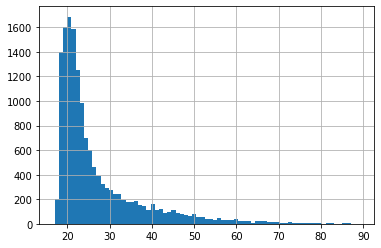

In [4]:
import matplotlib.pyplot as plt
df['Age'].hist(bins=len(df['Age'].unique()))
plt.show()

As we can see, the updated age distribution seems much more reasonable, with fewer 17-year-olds relative to 18-, 19-, and 20-year-olds.

Now let's load distances from the EMME LoS matrices:

In [5]:
LoS = pd.read_csv('../../../LoS/Walk_Distances.csv')
zones = LoS['Origin'].unique().tolist()
dists = LoS['Data'].tolist()

not_found = set()
def find_distance(o, d):
    try:
        i = zones.index(o)
    except ValueError:
        not_found.add(o)
        return -1
    try:
        j = zones.index(d)
    except ValueError:
        not_found.add(d)
        return -1
    return dists[i*2392 + j] / 1000

df['Dist'] = df.apply(lambda x: find_distance(x.HomeZone, x.SchoolZone), axis =1)

In [6]:
df.to_csv('../../Data/TTS_2016/TTS_2016_Filtered.csv', index=True)